In [1]:
import pandas as pd
import numpy as np
import utils as ut
import matplotlib.pyplot as plt
import lightgbm as lgbm
import sklearn as sk

# Cargar datos

In [2]:
path = "data/ARIA_merged&selected/"

show = 0
pat = ut.leer_csv(path + "Patient_real.csv", show)
cur = ut.leer_csv(path + "Course_pi_diag.csv", show)
rtp = ut.leer_csv(path + "RTPlan_PS_Pres.csv", show)
rad = ut.leer_csv(path + "Radiation.csv", show)

sch = ut.leer_csv(path + "SchActivity.csv", show)

tr = ut.leer_csv(path + "TreatmentRecord.csv", show)

D:\miniconda3\envs\tfm2\lib\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (34,48) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


# Join

In [3]:
aux = rtp.merge(cur, on="CourseSer", how="left")
p4 = aux.PatientSer.value_counts()[aux.PatientSer.value_counts()==1].index # pacientes con un solo plan

In [4]:
sch["ScheduledStartTime"] = pd.to_datetime(sch["ScheduledStartTime"])
sch["ScheduledEndTime"] = pd.to_datetime(sch["ScheduledEndTime"])
sch["ActualStartDate"] = pd.to_datetime(sch["ActualStartDate"])
sch["ActualEndDate"] = pd.to_datetime(sch["ActualEndDate"])

In [5]:
sch2 = sch[(sch.PatientSer.isin(p4)) & (sch.ActualEndDate.notnull()) & (sch.ScheduledEndTime.notnull())\
          & (sch.ActualStartDate.notnull()) & (sch.ScheduledStartTime.notnull()) & (sch.ActualStartDate != sch.ActualEndDate)]

sch2["ScheduledDuration"] = (sch2.ScheduledEndTime - sch2.ScheduledStartTime).astype("int64")*1e-9/60
sch2["ActualDuration"] = (sch2.ActualEndDate - sch2.ActualStartDate).astype("int64")*1e-9/60
sch2 = sch2[(sch2.ActualDuration>1) & (sch2.ActualDuration<60)]

sch2 = sch2.drop(columns = ["ScheduledEndTime","ScheduledStartTime","ActualEndDate","ActualStartDate"])
sch2 = sch2.merge(pat, on="PatientSer", how="left").merge(rtp, on="CourseSer", how="left").merge(cur,on='CourseSer',how='left')
sch2.shape

<ipython-input-5-97424dc178eb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sch2["ScheduledDuration"] = (sch2.ScheduledEndTime - sch2.ScheduledStartTime).astype("int64")*1e-9/60
<ipython-input-5-97424dc178eb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sch2["ActualDuration"] = (sch2.ActualEndDate - sch2.ActualStartDate).astype("int64")*1e-9/60


(19844, 84)

# Limpieza

In [6]:
c_index = "ScheduledActivitySer"
c_elim = ['CourseSer','DiagnosisSer','RTPlanSer','PlanSetupSer','SeriesSer', 'PrescriptionSer',
              'PatientSer_y','PatientSer_x', 'FirstName','ScheduledDuration','Duration','DefaultDuration']
c_fechas = ['StartDateTime']
# c_num = ['ScheduledDuration']
c_num = []
c_nans = []

nun_th = 20
len_th = 40
num_div = -1

sch3, c_categ, elim, res = ut.limpiar_tabla(sch2, c_index, c_elim, c_fechas, c_num, c_nans, nun_th, len_th, num_div)
sch3 = sch3.drop(columns = c_fechas)
sch3.shape

(19844, 63)

# Train/test

In [7]:
le = sk.preprocessing.LabelEncoder()
for i in c_categ:
    sch3.loc[:,i] = le.fit_transform( sch3[i].astype(str) )

In [8]:
y = "ActualDuration"

np.random.seed(0)
i = np.random.choice(range(len(sch3)), size=15000, replace=False)
j = np.setdiff1d(range(len(sch3)), i)

y_tr = sch3[y].iloc[i]
y_te = sch3[y].iloc[j]
x_tr = sch3.iloc[i,:].drop(columns = y)
x_te = sch3.iloc[j,:].drop(columns = y)

print(len(x_tr))
print(len(y_tr))
print(len(x_te))
print(len(y_te))

15000
15000
4844
4844


In [9]:
train = lgbm.Dataset(x_tr, label = y_tr, categorical_feature = c_categ )
test  = lgbm.Dataset(x_te, label = y_te, categorical_feature = c_categ )

In [10]:
parameters = {
    'objective': 'regression',
    'metric': ['rmse'],
#     'metric': ['poisson'],
    'boosting': 'gbdt',
    'learning_rate': 0.1,
    'verbose': 1,
#     'force_col_wise': 'true',
    
    # params util to prevent overfitting:
#     'feature_fraction': 0.4,
#     'bagging_fraction': 0.4,
#     'bagging_freq': 8,
    'num_leaves': 60,
#     'path_smooth': 10,
#     'lambda_l1': 100,
#     'lambda_l2': 100,
#     'min_data_in_leaf': 10,
#     'max_depth': 20,
    
#     'max_bin': 255,
#     'min_data_in_bin': 3,
}

model = lgbm.train(parameters, train, categorical_feature = c_categ, 
                       valid_sets = [test, ],
                       num_boost_round = 5000,
                       early_stopping_rounds = 200,
                  )
# 4.28

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1044
[LightGBM] [Info] Number of data points in the train set: 15000, number of used features: 56
[LightGBM] [Info] Start training from score 13.397106
[1]	valid_0's rmse: 5.85904
Training until validation scores don't improve for 200 rounds
[2]	valid_0's rmse: 5.69745
[3]	valid_0's rmse: 5.55933
[4]	valid_0's rmse: 5.4297
[5]	valid_0's rmse: 5.31879
[6]	valid_0's rmse: 5.22576
[7]	valid_0's rmse: 5.14232
[8]	valid_0's rmse: 5.06731
[9]	valid_0's rmse: 5.00782
[10]	valid_0's rmse: 4.95346
[11]	valid_0's rmse: 4.90752
[12]	valid_0's rmse: 4.86776
[13]	valid_0's rmse: 4.82629
[14]	valid_0's rmse: 4.78847
[15]	valid_0's rmse: 4.75637
[16]	valid_0's rmse: 4.72757
[17]	valid_0's rmse: 4.70316
[18]	valid_0's rmse: 4.68181
[19]	valid_0's r

D:\miniconda3\envs\tfm2\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
D:\miniconda3\envs\tfm2\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))



[23]	valid_0's rmse: 4.59514
[24]	valid_0's rmse: 4.584
[25]	valid_0's rmse: 4.57108
[26]	valid_0's rmse: 4.55638
[27]	valid_0's rmse: 4.5453
[28]	valid_0's rmse: 4.53405
[29]	valid_0's rmse: 4.52583
[30]	valid_0's rmse: 4.51636
[31]	valid_0's rmse: 4.50618
[32]	valid_0's rmse: 4.49351
[33]	valid_0's rmse: 4.48751
[34]	valid_0's rmse: 4.48344
[35]	valid_0's rmse: 4.47598
[36]	valid_0's rmse: 4.46624
[37]	valid_0's rmse: 4.45665
[38]	valid_0's rmse: 4.44896
[39]	valid_0's rmse: 4.44245
[40]	valid_0's rmse: 4.43743
[41]	valid_0's rmse: 4.43398
[42]	valid_0's rmse: 4.4263
[43]	valid_0's rmse: 4.41952
[44]	valid_0's rmse: 4.41494
[45]	valid_0's rmse: 4.41263
[46]	valid_0's rmse: 4.40522
[47]	valid_0's rmse: 4.39863
[48]	valid_0's rmse: 4.39324
[49]	valid_0's rmse: 4.3913
[50]	valid_0's rmse: 4.38423
[51]	valid_0's rmse: 4.38165
[52]	valid_0's rmse: 4.37658
[53]	valid_0's rmse: 4.3714
[54]	valid_0's rmse: 4.3682
[55]	valid_0's rmse: 4.36575
[56]	valid_0's rmse: 4.35928
[57]	valid_0's rmse:

[310]	valid_0's rmse: 4.28131
[311]	valid_0's rmse: 4.28138
[312]	valid_0's rmse: 4.28215
[313]	valid_0's rmse: 4.28126
[314]	valid_0's rmse: 4.28111
[315]	valid_0's rmse: 4.28151
[316]	valid_0's rmse: 4.28164
[317]	valid_0's rmse: 4.28147
[318]	valid_0's rmse: 4.28146
[319]	valid_0's rmse: 4.2815
[320]	valid_0's rmse: 4.28142
[321]	valid_0's rmse: 4.28173
[322]	valid_0's rmse: 4.28222
[323]	valid_0's rmse: 4.28204
[324]	valid_0's rmse: 4.28228
[325]	valid_0's rmse: 4.28248
[326]	valid_0's rmse: 4.28237
[327]	valid_0's rmse: 4.28219
[328]	valid_0's rmse: 4.28192
[329]	valid_0's rmse: 4.28171
[330]	valid_0's rmse: 4.28174
[331]	valid_0's rmse: 4.28199
[332]	valid_0's rmse: 4.28208
[333]	valid_0's rmse: 4.28237
[334]	valid_0's rmse: 4.28304
[335]	valid_0's rmse: 4.28306
[336]	valid_0's rmse: 4.28301
[337]	valid_0's rmse: 4.28317
[338]	valid_0's rmse: 4.28313
[339]	valid_0's rmse: 4.2832
[340]	valid_0's rmse: 4.28288
[341]	valid_0's rmse: 4.28272
[342]	valid_0's rmse: 4.28293
[343]	valid_

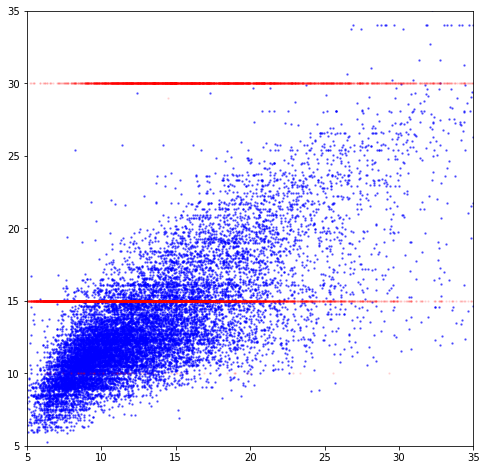

In [12]:
y_pred = model.predict(x_tr)

fig = plt.figure(1, figsize=(8,8))
plt.scatter(y_tr, y_pred, s = 2, alpha = 0.5, color = "blue")
plt.scatter(y_tr, sch2.ScheduledDuration[i], s = 2, alpha = 0.1, color = "red")

plt.xlim(5, 35)
plt.ylim(5, 35)
plt.show()

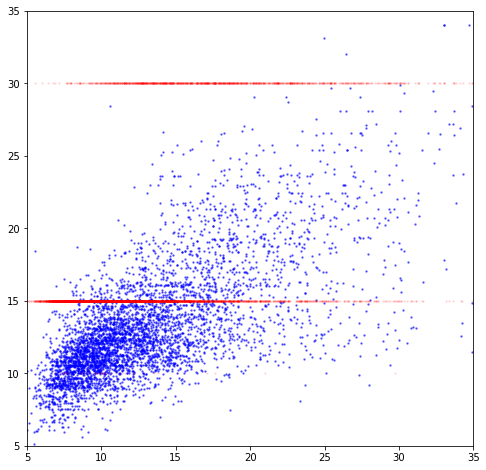

In [13]:
y_pred = model.predict(x_te)

fig = plt.figure(1, figsize=(8,8))
plt.scatter(y_te, y_pred, s=2, alpha = 0.5, color="blue")
plt.scatter(y_te, sch2.ScheduledDuration[j], s=2, alpha = 0.1, color="red")

plt.xlim(5, 35)
plt.ylim(5, 35)
plt.show()

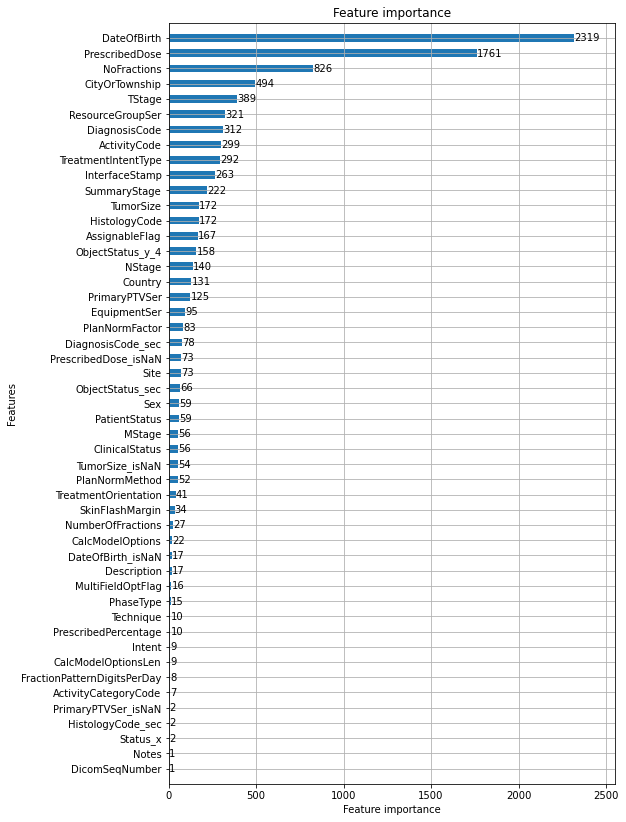

In [14]:
lgbm.plot_importance(model, height=0.5).figure.set_size_inches(8, 14)

<AxesSubplot:>

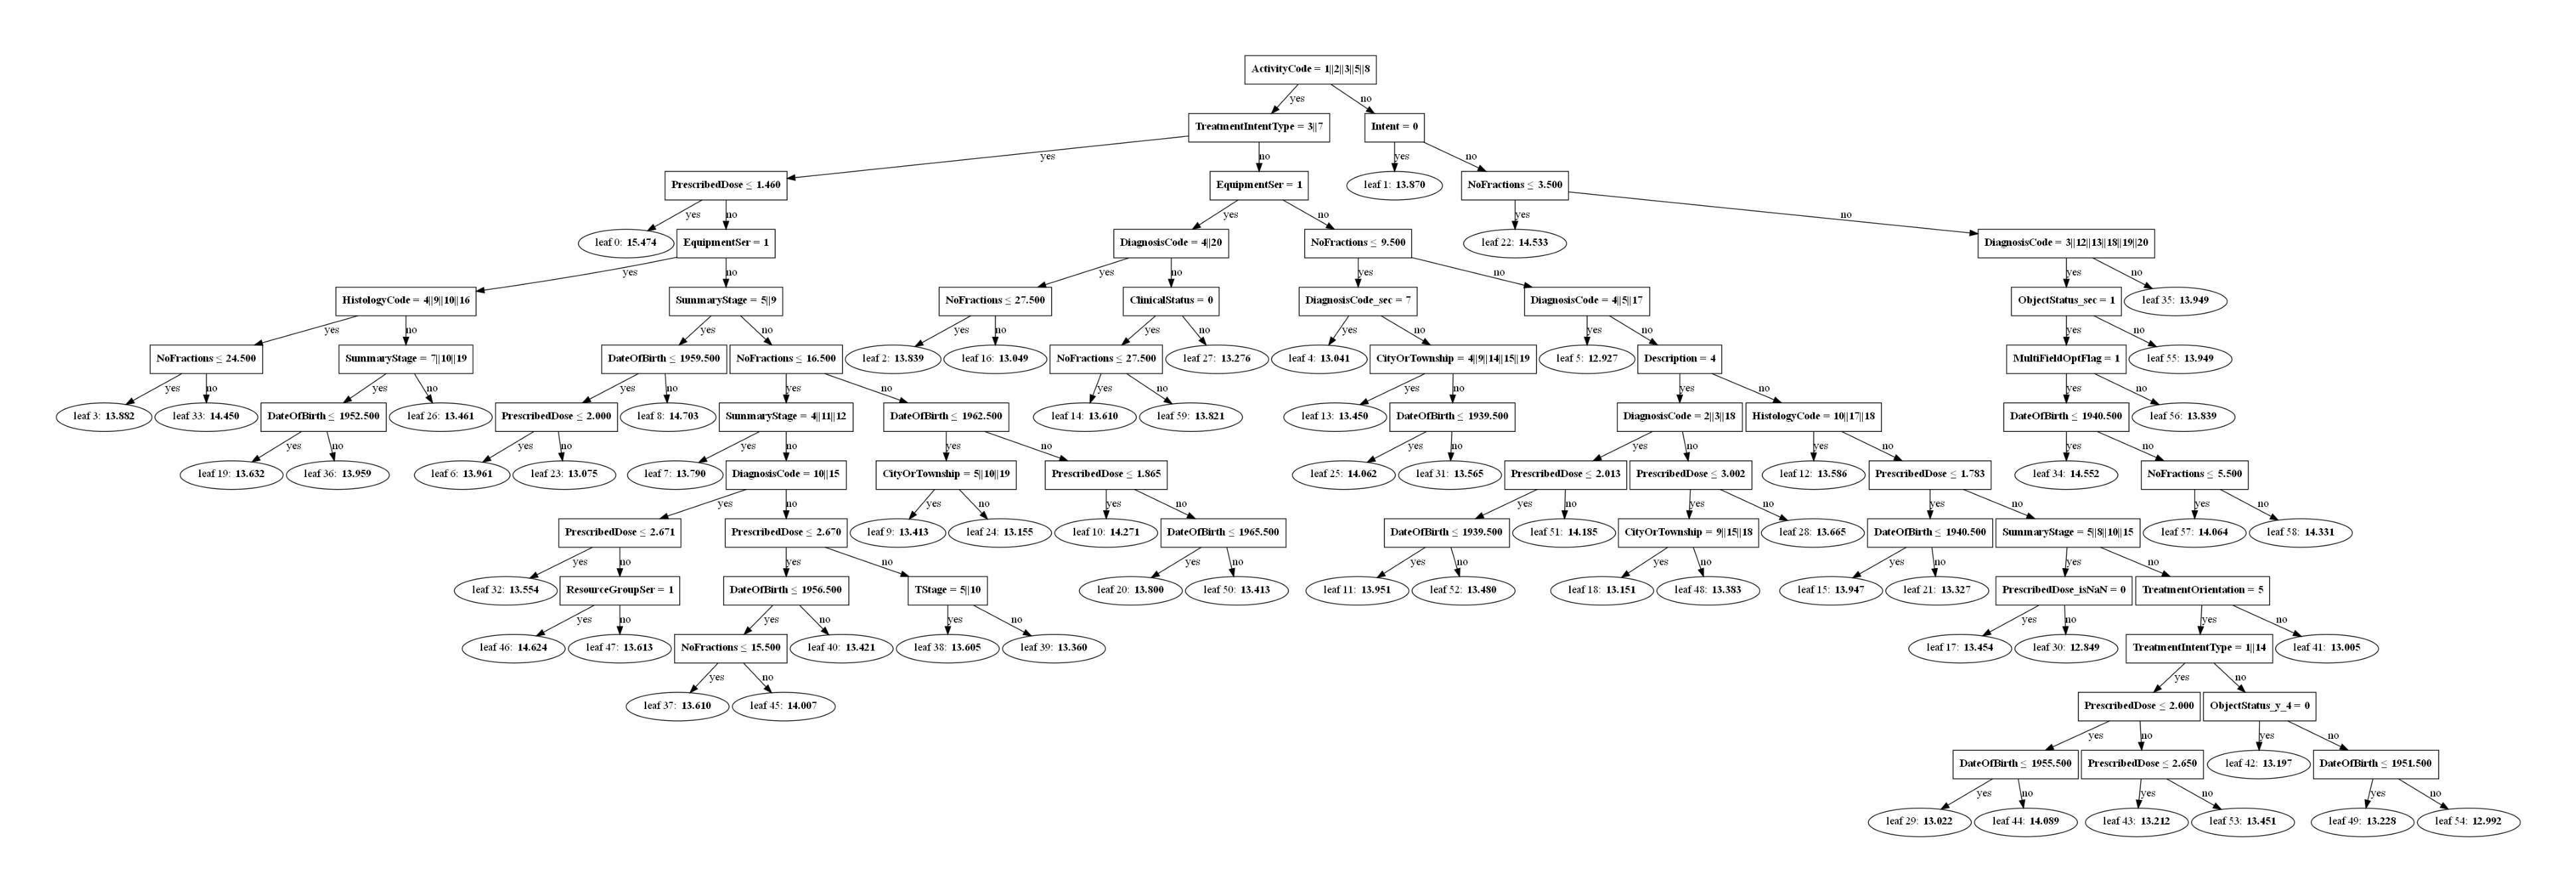

In [15]:
lgbm.plot_tree(model, orientation='vertical', dpi=800)

In [16]:
print(np.mean(y_pred))
print(np.mean(y_te))
print(np.mean(sch2.ScheduledDuration))

13.446054683931626
13.491560005505093
18.282805885910097


# Ex

In [ ]:
# uno = sch2.real[sch2.ActivityCode=="New Start"]
# dos = sch2.real[sch2.ActivityCode=="Fin Tratamiento"]
# tres= sch2.real
# # cua = sch2.real[sch2.ActivityCode=="Fin Tratamiento"]

# plt.hist(uno, bins=100, range=[0,40], density=True, alpha=0.5, color="red")
# plt.hist(dos, bins=100, range=[0,40], density=True, alpha=0.5, color="blue")
# plt.hist(tres,bins=100, range=[0,40], density=True, alpha=0.5, color="green")
# # plt.hist(cua ,bins=100, range=[0,40], density=True, alpha=0.5, color="yellow")
# plt.show()